# Maryland Car Accident Analysis

### Note
Data file 'maryland_accident_dataset_by_report_no.csv' has already been trimmed.
1. A single individual record is registered for each report case.
2. Records including NaN are deleted.
3. All individual registered are drivers. (PERSON_TYPE == 'D')

## Purpose
Differentiate car accident cases.  
Understand causes of casuality.  
Design solutions.

## Process
Preprocessing  
Clustering  
Modeling  
Insight

## The Driver's Fault
Find the most common condition and situation of faulty drivers in accidents.  
Identify the largest two issues.

### Preprocessing

In [1]:
# Import packages
import pandas as pd
import collections

In [2]:
# Read data as DataFrame
df = pd.read_csv('maryland_accident_dataset_by_report_no.csv')
# df = pd.read_csv('maryland_1year_nan_contained.csv', low_memory=False)
# Check total records
len(df.index)

29593

In [3]:
# To make all columns shown, find out the number of columns
n = len(df.columns)
# Change display setting
pd.options.display.max_columns = n

In [4]:
# Copy a new dataframe to modify
cdf = df.copy()

In [5]:
# Check the values of wanted column
collections.Counter(cdf.FAULT_FLAG)

Counter({'N': 17326, 'Y': 12267})

In [6]:
# Drop non-faulty drivers (Leave only FAULT_FLAT == 'Y')
fault_df = cdf[cdf.FAULT_FLAG == 'Y']

#### Drop attributes
Remaining attributes should satisfy following conditions.
1. It tells if the driver is qualified to drive.
2. It tells if the driver's cognitive function was hampered.
3. It tells if the driver's senses were restricted.
4. It tells the driver's physical aptness to drive.
5. It tells the motion of the car at and right before the accident.

In [7]:
# Get all column names
fault_df.columns

Index(['REPORT_NO', 'CDL_FLAG', 'CONDITION_CODE', 'EQUIP_PROB_CODE',
       'FAULT_FLAG', 'INJ_SEVER_CODE', 'PERSON_ID', 'PERSON_TYPE',
       'SAF_EQUIP_CODE', 'SEX_CODE', 'VEHICLE_ID', 'COLLISION_TYPE_CODE',
       'C_M_ZONE_FLAG', 'JUNCTION_CODE', 'LANE_CODE', 'LIGHT_CODE',
       'RD_COND_CODE', 'RD_DIV_CODE', 'SURF_COND_CODE', 'WEATHER_CODE',
       'AREA_DAMAGED_CODE_MAIN', 'BODY_TYPE_CODE', 'DAMAGE_CODE',
       'HIT_AND_RUN_FLAG', 'MOVEMENT_CODE', 'TIME', 'AGE'],
      dtype='object')

In [8]:
# Choose columns to delete first
del_cols = [
    'REPORT_NO', 'FAULT_FLAG', 'PERSON_ID',
    'PERSON_TYPE', 'VEHICLE_ID', 'TIME'
]

#### Reasons for neglection
REPORT_NO: Report number is not of concern.  
FAULT_FLAG: Every record already satisfies FAULT_FLAG == 'Y'.  
PERSON_ID: Individual ID is not of concern.  
PERSON_TYPE: Every record already satisfies PERSON_TYPE == 'D'.  
VEHICLE_ID: Vehicle ID is not of concern.  
TIME: Since there is no attribute that can tell the traffic situation for each hour, day or month span, TIME attribute can only indicate environmental conditions which are indicated in other attributes. Hence, this attribute is unncessary.

In [9]:
# Drop columns
drop_df = fault_df.drop(del_cols, axis=1)

In [10]:
# Get all left column names
drop_df.columns

Index(['CDL_FLAG', 'CONDITION_CODE', 'EQUIP_PROB_CODE', 'INJ_SEVER_CODE',
       'SAF_EQUIP_CODE', 'SEX_CODE', 'COLLISION_TYPE_CODE', 'C_M_ZONE_FLAG',
       'JUNCTION_CODE', 'LANE_CODE', 'LIGHT_CODE', 'RD_COND_CODE',
       'RD_DIV_CODE', 'SURF_COND_CODE', 'WEATHER_CODE',
       'AREA_DAMAGED_CODE_MAIN', 'BODY_TYPE_CODE', 'DAMAGE_CODE',
       'HIT_AND_RUN_FLAG', 'MOVEMENT_CODE', 'AGE'],
      dtype='object')

In [11]:
# Change categorical values with only two options to numerical values
d = {
    'CDL_FLAG': {'N': 0, 'Y': 1},
    'SEX_CODE': {'F': 0, 'M': 1},
    'C_M_ZONE_FLAG': {'N': 0, 'Y': 1},
    'HIT_AND_RUN_FLAG': {'N': 0, 'Y': 1}
}

rdf = drop_df.replace(d)

In [12]:
# Scale AGE
# Since AGE has values greater than any other column, its values should be scaled
scaled_df = rdf.copy()
scaled_df['AGE'] = (rdf['AGE'] - rdf['AGE'].min()) / (rdf['AGE'].max() - rdf['AGE'].min())
# scaled_df['AGE'] = (rdf['AGE'] - rdf['AGE'].mean()) / rdf['AGE'].std()

In [13]:
# Dummify all categorical data except INJ_SEVER_CODE
dum_cols = [
    'CONDITION_CODE', 'EQUIP_PROB_CODE', 'SAF_EQUIP_CODE', 'COLLISION_TYPE_CODE',
    'JUNCTION_CODE', 'LANE_CODE', 'LIGHT_CODE', 'RD_COND_CODE', 'RD_DIV_CODE',
    'SURF_COND_CODE', 'WEATHER_CODE', 'AREA_DAMAGED_CODE_MAIN', 'BODY_TYPE_CODE',
    'DAMAGE_CODE', 'MOVEMENT_CODE'
]

dum_df = pd.get_dummies(scaled_df, columns=dum_cols)

In [14]:
# Separate INJ_SEVER_CODE
preprocessed_df = dum_df.drop('INJ_SEVER_CODE', axis=1)

In [15]:
# To make all columns shown, find out the number of columns
n = len(dum_df.columns)
# Change display setting
pd.options.display.max_columns = n

### Clustering

#### k-means

In [16]:
# Import package
from sklearn.cluster import KMeans

In [17]:
# Fit
n_clusters = 5
kmodel = KMeans(n_clusters=n_clusters)
kmodel.fit(preprocessed_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:
# Predicted labels
predicted_labels = kmodel.labels_
drop_df['kmeans_labels'] = predicted_labels

#### Silhouette

In [19]:
# Import packages
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm
from matplotlib import pyplot as plt

import numpy as np

In [20]:
# Silhouette average
savg = silhouette_score(preprocessed_df, drop_df['kmeans_labels'])

In [21]:
# Silhouette value of each data
sval = silhouette_samples(preprocessed_df, drop_df['kmeans_labels'])

In [22]:
def plot_silhouette(X_df, labels):
    cluster_labels = sorted(np.unique(labels))
    n_clusters = len(cluster_labels)
    
    plt.figure()

    # axis setting
    ax = plt.gca()
    ax.set_xlim([-0.5, 1])
    ax.set_ylim([0, X_df.shape[0] + (n_clusters + 1) * 10])

    y_lower = 10
    
    silhouette_avg = silhouette_score(X_df, labels)
    print("k : {}".format(n_clusters))
    print("silhouette_avg : {}".format(silhouette_avg))
    data_silhouette_values = silhouette_samples(X_df, labels)

    for i in cluster_labels:
        # 특정 클러스터의 silhouette 값만 추출
        ith_cluster_silhouette_values = data_silhouette_values[labels == i]
        
        # 내림차순으로 정렬
        ith_cluster_silhouette_values.sort()

        # 해당 클러스터의 크기
        size_cluster_i = len(ith_cluster_silhouette_values)
       
        # 클러스터의 silhouette을 표시할 y축 최고값 결정
        y_upper = y_lower + size_cluster_i

        # 색
        color = cm.spectral(float(i) / n_clusters)
        
        # plot silhouette
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # y축에 클러스터 이름 표시
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # 다음 클러스터의 silhouette을 표시할 최저점 조정
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for k={}".format(n_clusters))
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # silhouette 평균 값을 나타내는 선
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    # y축 값 제거
    ax.set_yticks([])

    plt.show() 

k : 2
silhouette_avg : 0.10192774526930076


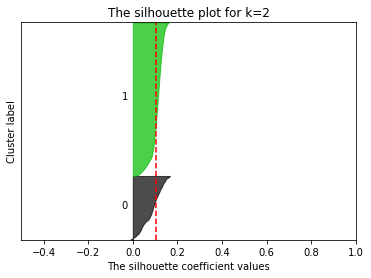

k : 3
silhouette_avg : 0.07540016968050582


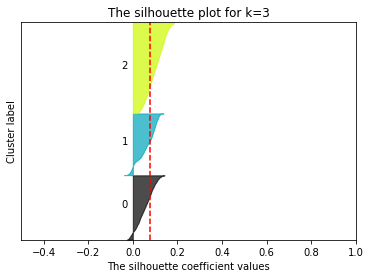

k : 4
silhouette_avg : 0.07144504937900881


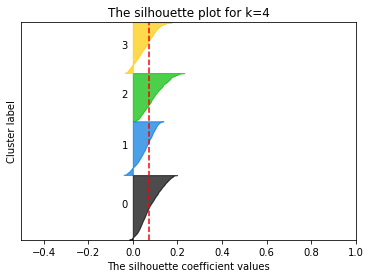

k : 5
silhouette_avg : 0.07125503002329577


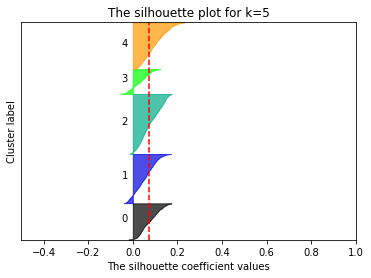

k : 6
silhouette_avg : 0.06800640863492484


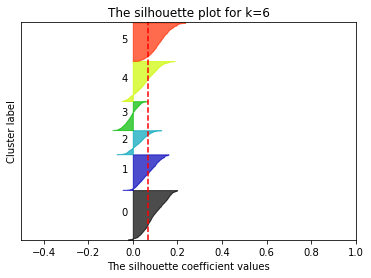

k : 7
silhouette_avg : 0.06330516590536482


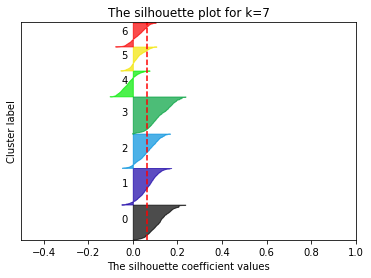

In [23]:
# Plot silhouette for choosing k
k_candidates = [2, 3, 4, 5, 6, 7]

for i in k_candidates:
    ith_model = KMeans(n_clusters=i)
    labels = ith_model.fit_predict(preprocessed_df)
    plot_silhouette(preprocessed_df, labels)

### Classification

#### Decision tree

In [24]:
# Import packages
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [25]:
# Split X, y
X, y = preprocessed_df, dum_df.INJ_SEVER_CODE

In [26]:
# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [27]:
# Model
class_weight = 'balanced'
max_depth = 5
dt_model = DecisionTreeClassifier(class_weight=class_weight, max_depth=max_depth)
dt_model.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [28]:
# Get predictions
y_pred_dt = dt_model.predict(X=X_test)

In [29]:
# Get score
dt_model.score(X=X_test, y=y_test)

0.35702641017280728

#### Graphviz

In [30]:
# Import package
from sklearn.tree import export_graphviz

import graphviz

In [31]:
# Export tree as .dot
with open('test_tree.dot', 'w') as f:
    export_graphviz(dt_model, f, feature_names=preprocessed_df.columns)

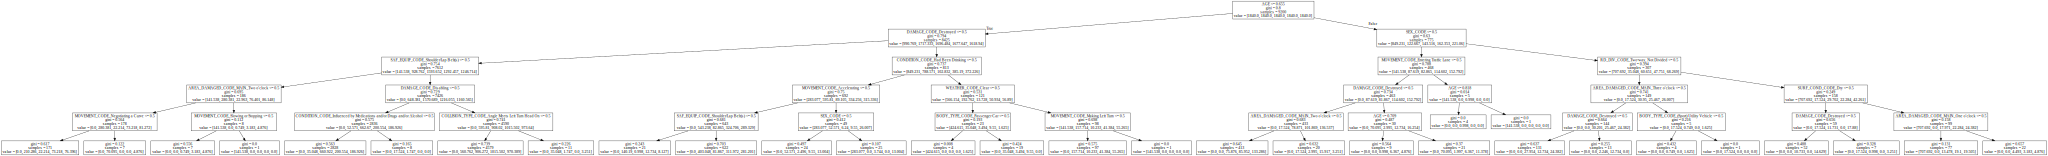

In [32]:
# Open .dot and visualize
with open('test_tree.dot', 'r') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)